### **This notebook contains a custom callback you may wish to copy and use  
It is a combination of the Keras callbacks Reduce Learning Rate on Plateau,  
Early Stopping and Model Checkpoint but eliminates some of the limitations  
of each. In addition it provides an easier to read summary of the model's  
performance at the end of each epoch. It also provides a handy feature  
that enables you to set the number of epochs to train for until a message  
asks if you wish to halt training on the current epoch by entering H or  
to enter an integer which will determine how many more epochs to run  
before the message appears again. This is very useful if you are training  
a model and decide the metrics are satisfactory and you want to end  
the model training early. Note the callback always returns your model  
with the weights set to those of the epoch which had the highest performance  
on the metric being monitored (accuracy or validation accuracy)  
The callback initially monitors training accuracy and will adjust the learning  
rate based on that until the accuracy reaches a user specified threshold  
level. Once that level of training accuracy is achieved the callback switches  
to monitoring validation loss and adjusts the learning rate based on that.  
the callback is of the form:  
callbacks=[LRA(model, base_model, patience, stop_patience, threshold,factor, dwell,
              batches, initial_epoch, epochs, ask_epoch )]    
 **where:**
 - **model** is your compiled model  
 - **base_model** is the name of your base_model if you are doing transfer learning.  
      for example you might have in your model  
      base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
      base_model.trainabel=False   During training you will be asked if you want to do fine tuning  
      If you enter F to the query, the base_model will be set to trainable by the callback
      If you are not doing transfer learning set base_model==None
 - **patience** is an integer that determines many consecutive epochs can occur before the learning rate
   will be adjusted (similar to patience parameter in Reduce Learning Rate on Plateau)
 
 - **stop_patience** is an integer that determines hom many consecutive epochs for which the
   learning rate was adjusted but no improvement in the monitored metric occurred before
   training is halted(similar to patience parameter in early stopping)
 
 - **threshold** is a float that determines the level that training accuracy must achieve
   before the callback switches over to monitoring validation loss. This  is useful for
   cases where the validation loss in early epochs tends to vary widely and can cause
   unwanted behavior when using the conventional Keras callbacks
 - **factor** is a float that determines the new learning rate by the equation lr=lr*factor.
   (similar to the factor parameter in Reduce Learning Rate on Plateau)
 - **dwell** is a boolean. It is used in the callback as part of an experiment on training
   models. If on a given epoch the metric being monitored fails to improve it means
   your model has moved to a location on the surface of Nspace (where N is the number
   of trainable parameters) that is NOT as favorable (poorer metric performance) than
   the position in Nspace you were in for the previous epoch. If dwell is set to True
   the callback loads the model with the weights from the previous (better metric value)
   epoch. Why move to a worse place if the place you were in previously was better. Then
   the learning rate is reduced for the next epoch of training. If dwell is set to false
   this action does not take place.
 - **batches** is an integer. It should be set to a value of 
   batches=int(number of traing samples/batch_size). During training the callback provides
   information during an epoch of the form
   'processing batch of batches  accuracy= accuracy  loss= loss where batch is the current 
    batch being processs, batches is as described above, accuracy is the current training
    accuracy and loss is the current loss. Typically the message would appear as
    processing batch 25 of 50  accuracy: 54%  loss: .04567. As each batch is processed
    these values are changed.    
 - **initial_epoch** is an integer. Typically set this to zero Itis used in the information
    printed out for each epoch. In the case where you train the model say with the
    basemodel weights frozen say you train for 10 epochs. Then you want to fine tune
    the model and train for more eppochs for the second training session you would
    reinstantiate the callback and set initial_epoch=10.
 - **epochs** an integer value for the number of epochs to train
 - **ask_epoch** is either set to an integer value or None. If set to an integer it denotes
    the epoch number at which user input is requested. If the user enter H training is
    halted. If the user inters an integer it represents how many more epochs to run
    before you are asked for the user input again. If the user enters F the base_model
    is made trainable If ask_epoch is set to None the
    user is NOT asked to provide any input. This feature is handy is when training your model
    and the metrics are either unsatisfactory and you want to stop training, or for the case
    where your metrics are satisfactory and there is no need to train any further. Note
    you model is always set to the weights for the epoch that had the beset metric
    performance. So if you halt the training you can still use the model for predictions.  
      
### ** Example of Use:
 callbacks=[LRA(model=my_model, base_model=base_model, patience=1,stop_patience=3,  
            threshold=.9, factor=.5, dwell=True,batches=85, initial_epoch=0 , epochs=20, ask_epoch=5)]
 this implies:
 - your model is my_model
 - base_model is the name of your base_model if you are doing transfer learning
 - after 1 epoch of no improvement the learning rate will be reduced
 - after 3 consecutive adjustment of the leaarning rate with no metric improve training terminates
 - once the training accuracy reaches 90% the callback adjust learning rate based on validation loss
 - when the learning rate is adjust the new learning rate is .5 X learning rate
 - if the current epoch's metric value did not improve, the weights for the prior epoch are loaded
   and the learning rate is reduced
 - 85 batches of data are run to complete an epoch 
 - the initial epoch is 0
 - train for 20 epochs
 - after the fifth epoch you will be asked if you want to halt training by entering H or enter 
   an integer denoting how many more epochs to run before you will be prompted again or enter
   F to make the base_model=trainable

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

### Define a function to show example training images

In [2]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [3]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)
    

### Define  a function to print text in RGB foreground and background colors

In [4]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### Define a subclass of Keras callbacks that will control the learning rate and print
### training data in spreadsheet format. The callback also includes a feature to
### periodically ask if you want to train for N more epochs or halt

In [5]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

### Define a function to plot the training data

In [6]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define a function to create confusion matrix and classification report

In [7]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### define a function to save the model and the associated class_dict.csv file

In [8]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

### define a function that uses the trained model and the
### class_dict.csv file to predict images

In [9]:
def predictor(sdir, csv_path,  model_path, averaged=True, verbose=True):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    class_count=len(class_df['class'].unique())
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)    
    scale=class_df['scale by'].iloc[0] 
    image_list=[]
    # determine value to scale image pixels by
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
    path_list=[]
    paths=os.listdir(sdir)    
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    if verbose:
        print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list) 
    image_list=[]
    file_list=[]
    good_image_count=0
    for i in range (image_count):        
        try:
            img=cv2.imread(path_list[i])
            img=cv2.resize(img, img_size)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            good_image_count +=1
            img=img*s2 - s1             
            image_list.append(img)
            file_name=os.path.split(path_list[i])[1]
            file_list.append(file_name)
        except:
            if verbose:
                print ( path_list[i], ' is an invalid image file')
    if good_image_count==1: # if only a single image need to expand dimensions
        averaged=True
    image_array=np.array(image_list)    
    # make predictions on images, sum the probabilities of each class then find class index with
    # highest probability
    preds=model.predict(image_array)    
    if averaged:
        psum=[]
        for i in range (class_count): # create all 0 values list
            psum.append(0)    
        for p in preds: # iterate over all predictions
            for i in range (class_count):
                psum[i]=psum[i] + p[i]  # sum the probabilities   
        index=np.argmax(psum) # find the class index with the highest probability sum        
        klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
        prob=psum[index]/good_image_count  # get the probability average         
        # to show the correct image run predict again and select first image that has same index
        for img in image_array:  #iterate through the images    
            test_img=np.expand_dims(img, axis=0) # since it is a single image expand dimensions 
            test_index=np.argmax(model.predict(test_img)) # for this image find the class index with highest probability
            if test_index== index: # see if this image has the same index as was selected previously
                if verbose: # show image and print result if verbose=1
                    plt.axis('off')
                    plt.imshow(img) # show the image
                    print (f'predicted species is {klass} with a probability of {prob:6.4f} ')
                break # found an image that represents the predicted class      
        return klass, prob, img, None
    else: # create individual predictions for each image
        pred_class=[]
        prob_list=[]
        for i, p in enumerate(preds):
            index=np.argmax(p) # find the class index with the highest probability sum
            klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
            image_file= file_list[i]
            pred_class.append(klass)
            prob_list.append(p[index])            
        Fseries=pd.Series(file_list, name='image file')
        Lseries=pd.Series(pred_class, name= 'species')
        Pseries=pd.Series(prob_list, name='probability')
        df=pd.concat([Fseries, Lseries, Pseries], axis=1)
        if verbose:
            length= len(df)
            print (df.head(length))
        return None, None, None, df

### define a function tha takes in a dataframe df, and integer max_size and a string column
### and returns a dataframe where the number of samples for any class specified by column
### is limited to max samples

In [10]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

### input an image

(3456, 3456, 3)


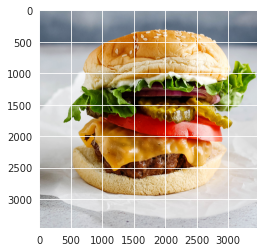

In [12]:
img_path=r'../input/indian-food-classification/Food Classification/burger/001.jpg'
img=plt.imread(img_path)
print (img.shape)
imshow(img)


### define function to preprocess the dataframe

In [13]:
def preprocess (sdir, trsplit, vsplit, random_seed):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=random_seed, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=random_seed, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df
    

In [14]:
sdir=r'../input/indian-food-classification/Food Classification'
train_df, test_df, valid_df= preprocess(sdir, .8,.1, 123)

train_df length:  5016   test_df length:  628   valid_df length:  627
chapati          330
kadai_paneer     329
chole_bhature    329
chai             305
fried_rice       284
pav_bhaji        282
butter_naan      263
dal_makhani      257
momos            255
masala_dosa      249
idli             248
burger           247
jalebi           238
kaathi_rolls     234
dhokla           231
pakode           222
samosa           210
pizza            209
kulfi            190
paani_puri       104
Name: labels, dtype: int64


### train_df is  not balanced . Limit max_samples in a class to 238
### enhance the train_df with augmented images  for under represented classes

In [15]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    else:
        ndf=train_df
    print (list(ndf['labels'].value_counts()) )
    return ndf 

In [16]:
max_samples= 238
min_samples=0
column='labels'
working_dir = r'./'
img_size=(224,224)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 234, 231, 222, 210, 209, 190, 104]
Found 231 validated image filenames.
Found 234 validated image filenames.
Found 210 validated image filenames.
Found 222 validated image filenames.
Found 209 validated image filenames.
Found 190 validated image filenames.
Found 104 validated image filenames.
Total Augmented images created=  266
[238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]


### The ndf dataframe is now balanced with 238 samples per class

### create train, test and validation generators

In [17]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  4   test steps:  157


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 4759 validated image filenames belonging to 20 classes.
Found 627 validated image filenames belonging to 20 classes.
Found 627 validated image filenames belonging to 20 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


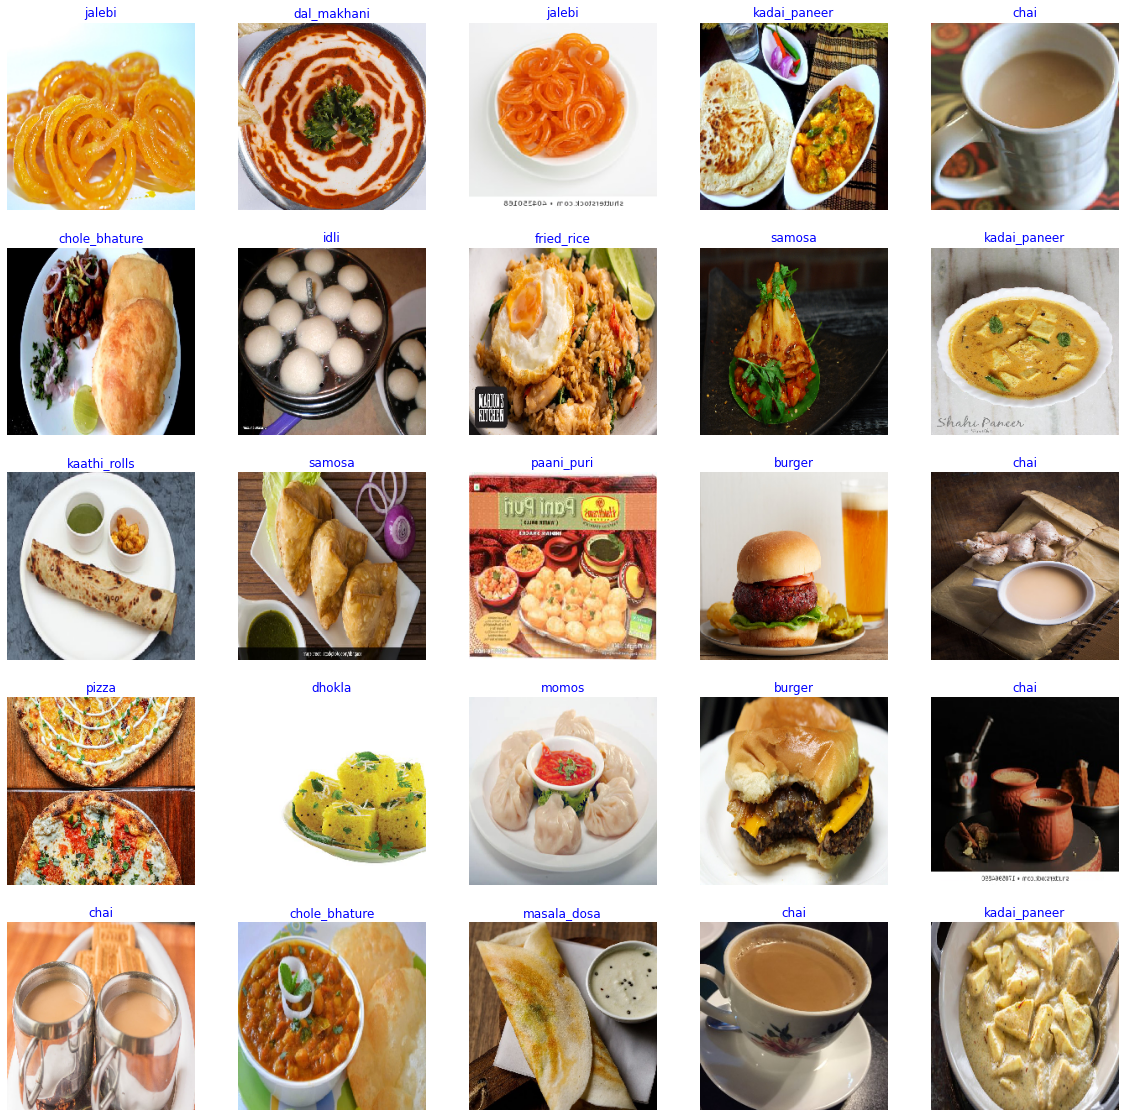

In [18]:
show_image_samples(train_gen)


### create the model

In [19]:
model_name='EfficientNetB2'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

31793152/31790344 [==============================] - 0s 0us/step


### instantiate the custom callback and train the model

In [20]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     8.234   57.806   6.48824  82.137   0.00100  0.00100  accuracy     0.00    195.50 

 2 /40     5.508   85.396   4.70022  88.357   0.00100  0.00100  accuracy    47.73    140.96 

 3 /40     3.960   91.784   3.46324  89.155   0.00100  0.00100  val_loss    26.32    140.78 

 4 /40     2.838   94.810   2.54230  90.909   0.00100  0.00100  val_loss    26.59    140.28 

 5 /40     2.009   96.764   1.87679  90.909   0.00100  0.00100  val_loss    26.18    140.07 

enter H to halt  or an integer for number of epochs to run then ask again



 5


 training will continue until epoch 10

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     1.436   97.647   1.44321  91.069   0.00100  0.00100  val_loss    23.10    140.03 

 7 /40     1.037   98.592   1.11854  90.590   0.00100  0.00100  val_loss    22.50    139.76 

 8 /40     0.781   98.697   0.93309  90.909   0.00100  0.00100  val_loss    16.58    139.56 

 9 /40     0.625   99.181   0.80565  91.866   0.00100  0.00100  val_loss    13.66    140.17 

10 /40     0.527   99.328   0.76614  91.228   0.00100  0.00100  val_loss     4.90    139.82 

enter H to halt  or an integer for number of epochs to run then ask again



 2


 training will continue until epoch 12

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

11 /40     0.461   99.391   0.69777  91.388   0.00100  0.00100  val_loss     8.92    139.63 

12 /40     0.427   99.181   0.68466  91.388   0.00100  0.00100  val_loss     1.88    139.86 

enter H to halt  or an integer for number of epochs to run then ask again



 h


training has been halted at epoch 12 due to user input

Training is completed - model is set with weights from epoch 12 

training elapsed time was 0.0 hours, 32.0 minutes, 7.34 seconds)



### evaluate model on the test set then save the model

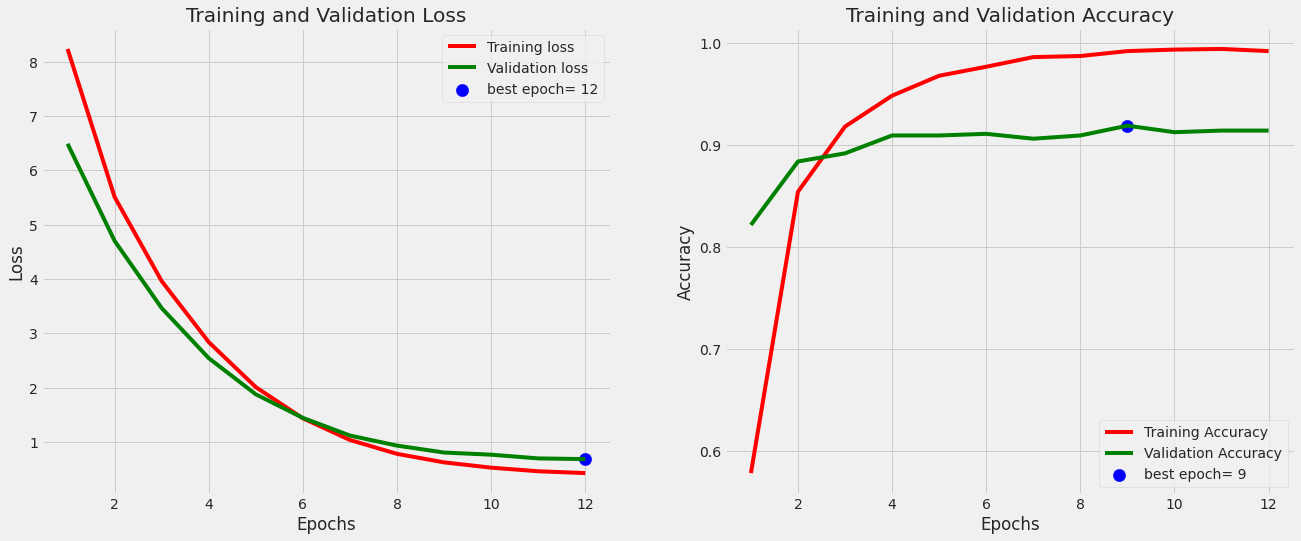

157/157 [==============================] - 22s 139ms/step - loss: 0.6452 - accuracy: 0.9155
accuracy on the test set is 91.55 %

model was saved as ./EfficientNetB2-indian food-91.54.h5

class csv file was saved as ./class_dict.csv



In [21]:
tr_plot(history,0)
subject='indian food'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

### make predictions on test set and generate confusion matrix and classification report

157/157 [==============================] - 19s 108ms/step


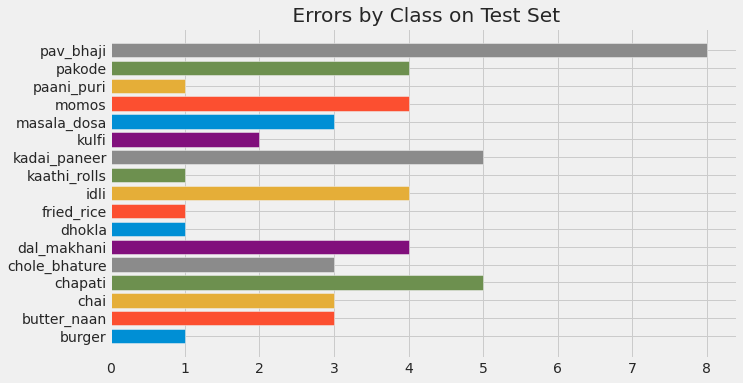

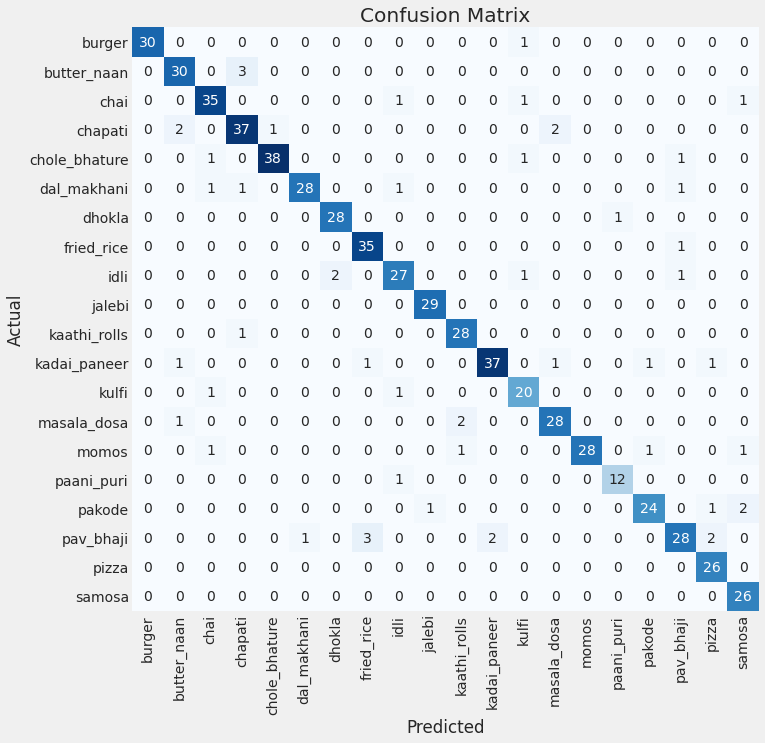

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       1.00      0.97      0.98        31
  butter_naan       0.88      0.91      0.90        33
         chai       0.90      0.92      0.91        38
      chapati       0.88      0.88      0.88        42
chole_bhature       0.97      0.93      0.95        41
  dal_makhani       0.97      0.88      0.92        32
       dhokla       0.93      0.97      0.95        29
   fried_rice       0.90      0.97      0.93        36
         idli       0.87      0.87      0.87        31
       jalebi       0.97      1.00      0.98        29
 kaathi_rolls       0.90      0.97      0.93        29
 kadai_paneer       0.95      0.88      0.91        42
        kulfi       0.83      0.91      0.87        22
  masala_dosa       0.90      0.90      0.90        31
        momos       1.00      0.88      0.93        32
   paani_puri       0.92      0.92      0.92        13
       pakode    

In [22]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

### to test the classifier kernel create a directory with a single image in it

In [23]:
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image of a burger
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print (os.listdir(store_path))

['001.jpg']


### use the predictor function to classify the single image

 image is of class burger with a probability of  96.41 %



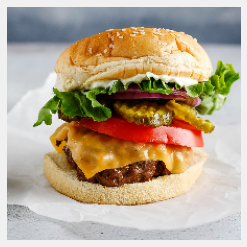

In [24]:
csv_path=csv_save_loc # path to class_dict.csv
model_path=model_save_loc # path to the trained model
klass, prob, img, df =predictor(store_path, csv_path,  model_path, averaged=True, verbose=False) # run the classifier
msg=f' image is of class {klass} with a probability of {prob * 100: 6.2f} %'
plt.axis('off')
plt.imshow(img)
print_in_color(msg, (0,255,255), (65,85,55))